# Problem set 2. Incomplete markets

Manuel Amador

Julia 1.12.1



In [1]:
import Pkg
Pkg.activate(@__DIR__)  # Activate a local environment 
# Pkg.add("Plots")
Pkg.instantiate()   # Install the required packages if not already installed
using Plots

  Activating project at `c:\Users\amador\Dropbox\Teaching\mn grad\mn 8107 Spring 2026\problem sets and exams\PSET2`
┌ Warning: The active manifest file has dependencies that were resolved with a different julia version (1.11.4). Unexpected behavior may occur.
└ @ nothing C:\Users\amador\Dropbox\Teaching\mn grad\mn 8107 Spring 2026\problem sets and exams\PSET2\Manifest.toml:0
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\Users\amador\.julia\juliaup\julia-1.12.1+0.x64.w64.mingw32\share\julia\stdlib\v1.12\Pkg\src\API.jl:1227
   Installed GR_jll ─────────────── v0.73.13+0
   Installed Xorg_libxkbfile_jll ── v1.1.2+1
   Installed Xorg_xkbcomp_jll ───── v1.4.6+1
   Installed Xorg_libXinerama_jll ─ v1.1.5+0
   Installed Xorg_libSM_jll ─────── v1.2.4+0
   Installed xkbcommon_jll ──────── v1.4.1+2
   Installed HTTP ───────────────── v1.10

## Parameters 

In [2]:
Base.@kwdef struct HHParameters{T1, T2, T3, R1, S}
    β::R1 = 0.95
    R::R1 = 1.04 
    ρ::R1 = 2.0 
    ϕ::R1 = 0.0
    w::R1 = 1.0 
    P::T1 = [0.5 0.5; 0.2 0.8]
    l::T2 = [0.5, 1.0]
    y::T2 = w * l 
    ytilde::T2 = y .- (R - 1) * ϕ
    ahat_min::R1 = 0.0
    ahat_max::R1 = 15.0
    points::S = 10_000
    ahat_grid::T3 = range(ahat_min, ahat_max, points)
end

In [3]:
u(c, m) = c ^ (1 - m.ρ) / (1 - m.ρ)    

u (generic function with 1 method)

## Solving the household problem 

In [4]:
function solve_household(par; v0 = zeros(length(par.ahat_grid), length(par.ytilde)),  tol = 1e-4)

    # unpacking 
    (; ahat_grid, ytilde, R, β, P) = par
    
    v1 = similar(v0)
    pol = similar(v0, Int)
    βv = similar(v1)
    
    n = length(ahat_grid)
    
    iter = 0
    @inbounds while true
        distance = zero(eltype(v0))
        iter += 1 
                
        for s in eachindex(ytilde)
            for i in eachindex(ahat_grid)
                accum = zero(eltype(v0))
                for sprime in eachindex(ytilde)
                    accum += β * P[s, sprime] * v0[i, sprime]
                end
                βv[i, s] = accum
            end 
        end
#
#       or alternatively using LinearAlgebra package: 
#       mul!(βv, v0, P', β, zero(eltype(βv))) 

        for s in eachindex(ytilde) 
            pol_i = 1
            for i in eachindex(ahat_grid)
                just_started = true 
                vmax = zero(eltype(v0))
                for j in pol_i:n
                    c = R * ahat_grid[i] + ytilde[s] - ahat_grid[j]
                    if c > 0
                        v_tmp = u(c, par) + βv[j, s]
                        if just_started
                            vmax = v_tmp
                            pol_i = j
                            just_started = false
                        elseif v_tmp > vmax 
                            vmax = v_tmp 
                            pol_i = j
                        else 
                            break 
                        end 
                    end 
                end 
                v1[i, s] = vmax
                pol[i, s] = pol_i
                dis = abs(vmax - v0[i, s])
                if dis > distance
                    distance = dis
                end 
            end 
        end 
        
        # mod(iter, 100) == 1 && println(iter, " ", distance)
        
        if distance < tol
            break
        else 
            v0, v1 = v1, v0 
        end 
    end 
    return (v = v1, pol = pol, m = par)
end 
    

solve_household (generic function with 1 method)

In [5]:
@time sol = solve_household(HHParameters());

## Policy plots 

In [6]:
function do_pol_plot(sol)
    (; pol, m) = sol  
    
    zmax = m.R * m.ahat_grid[end] + maximum(m.y)
    
    figs = []
    for s in eachindex(m.ytilde)
        f = plot(xlims = (0, zmax), ylims = (0, zmax), title = "Policy function for state $s", legend = false)

        x_vals = [m.R * a + m.ytilde[s] for a in m.ahat_grid]
        y_vals = [[m.R * m.ahat_grid[pol[i, s]] + yprime for i in eachindex(m.ahat_grid)] for yprime in m.ytilde]

        plot!(f, x_vals, x_vals, linestyle = :dash)
        ylabel!(f, "cash in hands, z'")
        xlabel!(f,  "cash in hands, z")
        for y_val in y_vals
            plot!(f, x_vals, y_val)
        end 
        push!(figs, f)
    end
    plot(figs..., layout = (1, 2), size = (800, 400))
end 

do_pol_plot (generic function with 1 method)

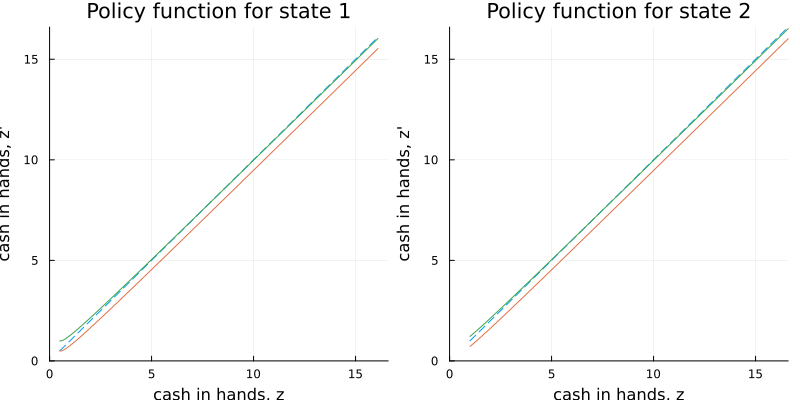

In [7]:
do_pol_plot(sol)  # watch out for the time to first plot problem. 

## Stationary Distribution 

In [8]:
function compute_stationary_distribution(sol; tol = 1e-7, init_pdf = fill(1.0 / prod(size(sol.v)), size(sol.v)) )
    (; pol, m) = sol
    
    pdf_0 = copy(init_pdf)
    pdf_1 = similar(init_pdf)
    
    while true 
        fill!(pdf_1, zero(eltype(pdf_0)))
        
        for i in eachindex(m.ahat_grid)
            for s in eachindex(m.ytilde)
                for sprime in eachindex(m.ytilde)
                    pdf_1[pol[i, s], sprime] += m.P[s, sprime] * pdf_0[i, s]
                end
            end 
        end
        
        distance = zero(eltype(pdf_0))
        for (a, b) in zip(pdf_0, pdf_1)
            distance = max(abs(a - b), distance)
        end
        
        (distance < tol) && break 
        pdf_0, pdf_1 = pdf_1, pdf_0
    end 
    return pdf_1
end 

function do_pdf_plot(sol, pdf) 
    
    p1 = plot(sol.m.ahat_grid, sum(pdf, dims = 2)[:, 1], title = "PDF")
    p2 = plot(sol.m.ahat_grid, cumsum(sum(pdf, dims = 2)[:, 1]), title= "CDF")
    fig = plot(p1, p2, layout = (2, 1), size = (800, 600), legend = false, xlabel = "cash in hands, z")

    return fig
end 


do_pdf_plot (generic function with 1 method)

  0.245165 seconds (52.57 k allocations: 2.963 MiB, 67.56% compilation time)


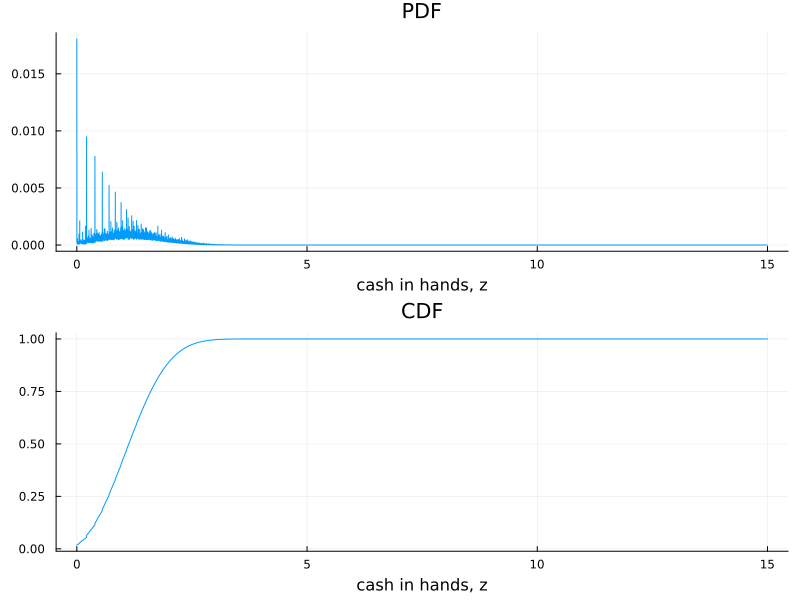

In [9]:
@time pdf = compute_stationary_distribution(sol);

do_pdf_plot(sol, pdf)